https://towardsdatascience.com/retrieval-augmented-generation-rag-from-theory-to-langchain-implementation-4e9bd5f6a4f2

# RAG using Langchain and Weviate Vector DB

In [1]:
#!pip install langchain  weaviate-client
#!pip install -U langchain-huggingface
#pip install openai==0.28

### Setup

In [49]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
import numpy as np
from torch import cuda
from langchain.vectorstores import Weaviate
import weaviate
from weaviate.embedded import EmbeddedOptions
from langchain.text_splitter import CharacterTextSplitter
from nltk import sent_tokenize
import pandas as pd 
from sklearn.model_selection import train_test_split
from langchain.embeddings import HuggingFaceEmbeddings
import seaborn as sea
import matplotlib.pyplot as plt
import Levenshtein as lev

### Data Treatment

##### Access

In [6]:
dataframe = pd.read_parquet('../Datasets/pre_processed_dataframes/clean_df.parquet')
len(dataframe)
dataframe = dataframe[dataframe['language_name'] == 'English'].copy()
valid_categories = ['Entertainment']
dataframe = dataframe[dataframe['Category'].isin(valid_categories)]
dataframe = dataframe.reset_index(drop=True)
len(dataframe)

296

##### Split dataframe in knowledge base and test base

In [17]:
df_knowledge_base, df_test = train_test_split(dataframe, test_size=0.3, stratify=dataframe['Category'])
df_knowledge_base = df_knowledge_base.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(dataframe), len(df_knowledge_base), len(df_test)

(296, 207, 89)

##### Transform dataframe in txt files

In [18]:
texts = df_knowledge_base['description'].values

In [19]:
filename = 'data/enterteinment_news.txt'
with open(filename, 'w') as arquivo_saida:    
    for text in texts:
        splitted_texts = sent_tokenize(text)
        for s in splitted_texts:
            arquivo_saida.write(s + '\n')
loader = TextLoader(filename)
documents = loader.load()

### Chunks creation

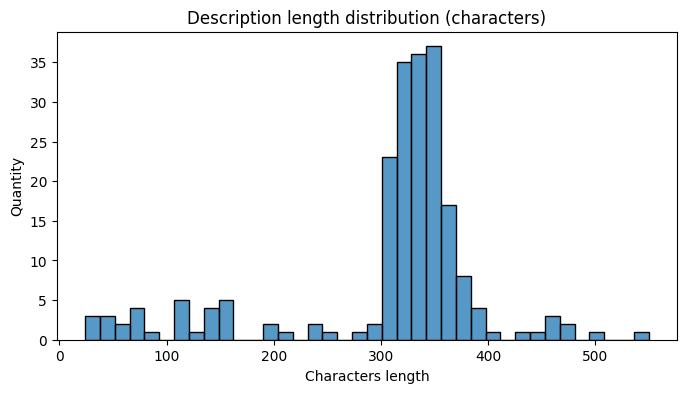

In [32]:
df_knowledge_base['len'] = df_knowledge_base['description'].apply(len)
plt.figure(figsize=(8, 4))
ax = sea.histplot(data=df_knowledge_base['len'])
ax = plt.title('Description length distribution (characters)')
ax = plt.xlabel('Characters length')
ax = plt.ylabel('Quantity')

In [34]:
mean_size = int(df_knowledge_base['len'].mean())

In [35]:
text_splitter = CharacterTextSplitter(chunk_size=mean_size, chunk_overlap=int(mean_size/2), separator=' ')
chunks = text_splitter.split_documents(documents)

In [36]:
print(df_knowledge_base.loc[0, 'description'])

The "virtual sets" used on The Mandalorian have been a game-changer for some filmmakers, creating an alternative to green- and blue-screen production that many think will almost completely replace the existing technology as it evolves. One example of where rear-screen projection technology is not fully "there" yet, though, comes from Guardians of the Galaxy vol. 3. ...


In [38]:
print(chunks[0].page_content)

The "virtual sets" used on The Mandalorian have been a game-changer for some filmmakers, creating an alternative to green- and blue-screen production that many think will almost completely replace the existing technology as it evolves.
One example of where rear-screen projection technology is not fully


### Embeddings

In [39]:
model_path='google-bert/bert-base-multilingual-uncased'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

embed_model = HuggingFaceEmbeddings(
    model_name=model_path,
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'device': 'cpu', 'batch_size': 32}
)

/tmp/ipykernel_714915/2267849621.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embed_model = HuggingFaceEmbeddings(
No sentence-transformers model found with name google-bert/bert-base-multilingual-uncased. Creating a new one with mean pooling.


### Vector Index

In [ ]:
client = weaviate.Client(
  embedded_options = EmbeddedOptions()
)

In [ ]:
vectorstore = Weaviate.from_documents(
    client = client,    
    documents = chunks,
    embedding = embed_model,
    by_text = False
)

### Retriever

In [85]:
retriever = vectorstore.as_retriever(search_type='similarity_score_threshold', 
                                     search_kwargs={'k': 3,
                                                    'score_threshold': 0.75})

### Generate

In [93]:
df_test = df_test.reset_index(drop=True)
texts = df_test['description'].values
idx = 32

text = texts[idx]
print('News title = ', df_test.loc[idx, 'title'])
print('News content = ', text)
print('\n')

retriver_result = retriever.get_relevant_documents(text)
retriver_list = []
for r in retriver_result:
    retriver_list.append(r.page_content)
    sim = np.round(lev.ratio(text, r.page_content), 3)
    print('Similarity = ', sim)
enriched_text = " ".join(retriver_list)

print('\nSimilar texts: \n')
print(enriched_text)


News title =  Batwoman: "Freeze" Photos Released
News content =  The CW has released a batch of photos for "Freeze", the third episode of Batwoman's third season. As the title suggests, the episode is expected to feature a new character taking on the gimmick of Mr. Freeze, after his cold gun is among the Batman villain trophies that were unleashed on Gotham in the Season 2 ...


Similarity =  0.879
Similarity =  0.628
Similarity =  0.408

Similar texts: 

"Freeze", the third episode of Batwoman's third season.
As the title suggests, the episode is expected to feature a new character taking on the gimmick of Mr.
Freeze, after his cold gun is among the Batman villain trophies that were unleashed on Gotham in the Season 2 ...
EXCLUSIVE: Oscilloscope has Captain America: Civil War in 2016 and he's gone on to make appearances in multiple Avengers films as well ...
The CW has released a batch of photos for "Freeze", the third episode of Batwoman's third season.
As the title suggests, the epi